In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy
import dataclasses

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp
import pprint

from fusiondls.geometry import *
from fusiondls.SOLPSreader import read_balance

from fusiondls import MagneticGeometry, SimulationInputs, run_dls, file_read, file_write
from fusiondls.analytic_cooling_curves import LfuncKallenbach

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *
from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [3]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [4]:
def translate_side(x):
    return x.split("_")[0][0] + x.split("_")[1][0]

translate_side("inner_lower")

'il'

In [5]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = read_balance(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)
                
            params["Xpoint"] = df[df["Xpoint"]==1].index[0]

            geom = MagneticGeometry(params["Bpol"], params["Btot"], params["R"], params["Z"], params["Spar"], params["Spol"], params["Xpoint"])

            
            eqb_alt[case][region][i] = geom
            
            # eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Prepare cooling curves

In [6]:
curves = {}
T = np.linspace(0, 200, 1000)

## radas

In [15]:
rd = dict(
    Ar = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc"),
    Ne = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\neon.nc"),
    N = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\nitrogen.nc")    
)

for species in rd.keys():
    curves[species] = {}
    ds = rd[species]

    for netau in ds.coords["dim_ne_tau"].values:
        rate = ds["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
        netau_name = netau
        curves[species][netau_name*1e3] = sp.interpolate.interp1d(
            ds.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
            fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
            )


## SOLPS

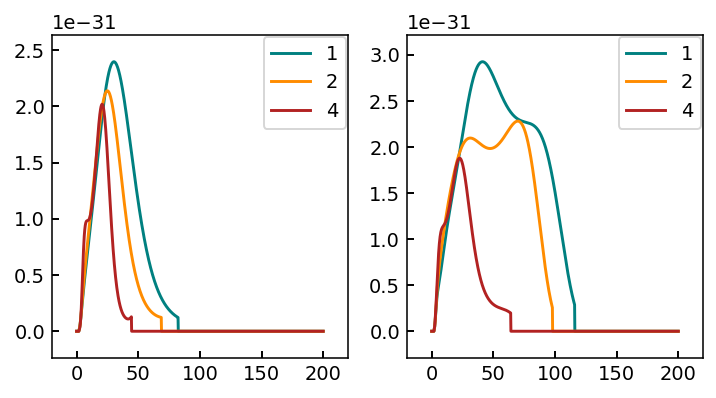

In [8]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()


## Custom

In [9]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

## Compare curves

### Outer

C:\Users\mikek\AppData\Local\Temp\ipykernel_28960\2597022885.py:41: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-10,1000)


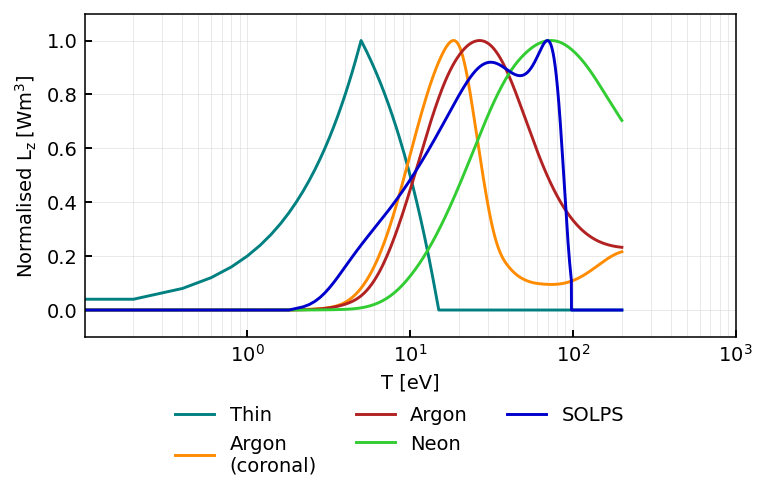

In [16]:
netau = 1e19

# curves_labels = {
#     "Thin" : "Thin",
#     "Nitrogen" : "Nitrogen (coronal)",
#     "Argon\n(coronal)" : curves["Ar"][1e21],
#     "Argon" : curves["Ar"][netau],
#     "Nitrogen" : curves["N"][netau],
#     "Neon" : curves["Ne"][netau],
#     "SOLPS" : curves["extracted_inner"][sepadd_select["inner_lower"]],    
# }

curves["set_outer"] = {
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Argon\n(coronal)" : curves["Ar"][1e21],
    r"Argon" : curves["Ar"][netau],
    r"Neon" : curves["Ne"][netau],
    "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],    
    
    # "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    # "Curve 2" : curves["Ar"][1e16*1e3],
    # "Curve 3" : curves["Ar"][1e14*1e3],
    # "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],
}
    
fig, ax = plt.subplots(figsize = (6,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 3, frameon = False)

ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))

ax.set_xscale("log")
ax.set_xlim(-10,1000)

# ax.set_yscale("log")
# ax.set_ylim(1e-3, 1)

ax.grid(which = "both", visible = True)
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_outer.pdf", format = "pdf")

### Inner

(-10.0, 200.0)

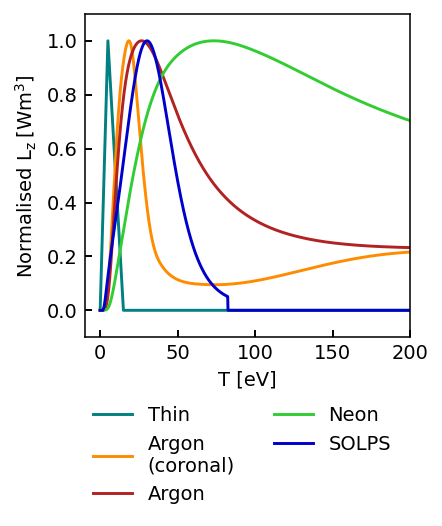

In [17]:
curves["set_inner"] = {
    
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Argon\n(coronal)" : curves["Ar"][1e21],
    "Argon" : curves["Ar"][netau],
    # "Nitrogen 1e19" : curves["N"][netau],
    "Neon" : curves["Ne"][netau],
    "SOLPS" : curves["extracted_inner"][sepadd_select["inner_lower"]],    
} 
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_inner"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_inner.pdf", format = "pdf")

# Profile grid

## Make profiles - outer

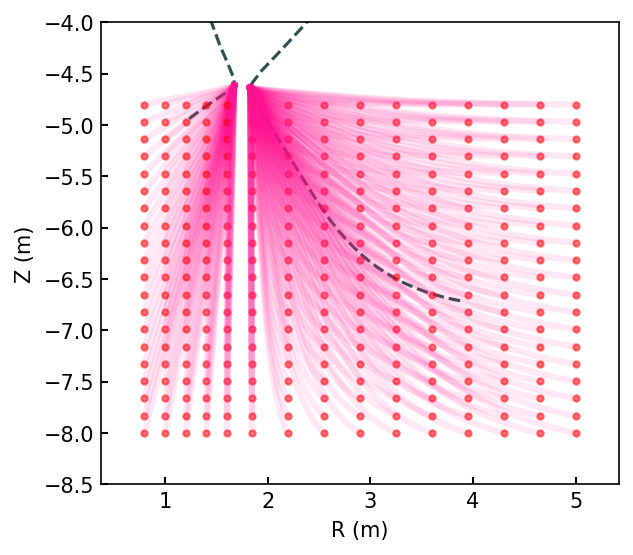

In [12]:
base_profile = dict(inner = eqb_alt['100MW_innerar_midplanepuff']["inner_lower"][sepadd_select["inner_lower"]], 
                    outer = eqb_alt['100MW_innerar_midplanepuff']["outer_lower"][sepadd_select["outer_lower"]])

base_profile_interp = {}

upper_lim = -4.8
lower_lim = -8
right_lim = 5
left_lim = 0.8
res = 10
xpoints = dict(
    inner = np.linspace(left_lim, 1.6, int(res/2)), 
    outer = np.linspace(1.85, right_lim, res))
ypoints = dict(
    inner = np.linspace(upper_lim, lower_lim, res*2), 
    outer = np.linspace(upper_lim, lower_lim, res*2))
# xpoints = dict(inner = np.linspace(0.5, 1.6, res), outer = np.linspace(2.5, 3.5, res))
# ypoints = dict(inner = np.linspace(-4.65, -8, res), outer = np.linspace(-4.65, -6, res))


fig, ax = plt.subplots(dpi = 150)

profiles_constBpol = {}
for side in ["inner", "outer"]:
    profiles_constBpol[side] = {}
    for x in xpoints[side]:
        profiles_constBpol[side][x] = {}
        for y in ypoints[side]:
            p2 = base_profile[side].copy()
            offsets = p2.get_offsets_strike_point([1, 0.9, 0.6, 0.59, 0.2, 0.1, 0.05, 0], x, y)
            
            # p2.recalculate_topology(constant_pitch = False, verbose = False)
            profiles_constBpol[side][x][y] = p2.offset_control_points(offsets, constant_pitch = False).geometry

        
    ax.plot(base_profile[side]["R"], base_profile[side]["Z"], ls = "--", c = "darkslategrey")

    for x in xpoints[side]:
        for y in ypoints[side]:
            profiles_constBpol[side][x][y].plot(ax = ax, mode = "RZ", color = "deeppink", ls = "-", lw = 3, alpha = 0.1)
            profile = profiles_constBpol[side][x][y]
            ax.plot(profile["R"][0], profile["Z"][0], marker = "o", color = "red", ms = 3, alpha = 0.5)
            
    base_x = base_profile[side]["R"][0]
    base_y = base_profile[side]["Z"][0]
    
    p2 = base_profile[side].copy()
    offsets = p2.get_offsets_strike_point([1, 0.9, 0.6, 0.59, 0.2, 0.1, 0.05, 0], base_x, base_y)
    base_profile_interp[side] = p2.offset_control_points(offsets, constant_pitch = False).geometry
# profiles_constBpitch = {}
# for side in ["inner", "outer"]:
#     profiles_constBpitch[side] = {}
#     for x in xpoints[side]:
#         profiles_constBpitch[side][x] = {}
#         for y in ypoints[side]:
#             p2 = base_profile[side].copy()
#             offsets = p2.get_offsets_strike_point([1, 0.9, 0.6, 0.59, 0.2, 0.1, 0.05, 0], x, y)
#             p2.offset_control_points(offsets)
#             # p2.recalculate_topology(constant_pitch = True, verbose = False)
#             profiles_constBpitch[side][x][y] = p2.offset_control_points(offsets, constant_pitch = False).geometry

ax.set_ylim(-8.5, -4.0)
ax.set_aspect("equal")
# ax.set_title("Profile shapes")
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_profiles.pdf", format = "pdf")

# Run DLS

In [14]:
curves["set_inner"]

{'Thin': <function __main__.<lambda>(temp)>,
 'SOLPS': <function code_comparison.solps_pp.SOLPScase.extract_cooling_curve.<locals>.fit(T)>}

In [92]:
def run_DLS(constants_input, profile, SparRange, slc, cvar, region, sepadd, hflux_corr=1):
    if "cooling_curve" not in constants_input.keys():
        print("WARNING: NO COOLING CURVE PROVIDED")

    df = slc.get_1d_poloidal_data(
        ["Ne"], sepadd=sepadd, region=region, target_first=True
    )
    nu = df["Ne"].iloc[-1]
    
    # This comes from the SOLPS comparison match for the specific SOL rings
    if "inner" in region:
        qpllu0 = 2.5e8 * 1.1
        kappa = 2.46 * 2500
        curve = curves["set_inner"]["Argon"]
    else:
        qpllu0 = 3.0e8 * 1.06
        kappa = 2500
        curve = curves["set_outer"]["Argon"]

    inputs = SimulationInputs(
        control_variable=cvar,
        SparRange=SparRange,
        qpllu0=qpllu0,
        nu0=nu,
        cz0=0.05,
        cooling_curve=curve,
        kappa0=slc.extract_kappa0(sepadd=sepadd, region=region),
        Ctol = 1e-5,
        Ttol = 1e-4,
        grid_refinement_ratio=5,
        grid_refinement_width=2,
        grid_resolution=10000,
    )
    
    try:
        out = run_dls(
            dataclasses.replace(inputs, **constants_input),
            profile,
            verbosity = 1
        )

    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(
        slc, out, cvar, impurity="Ar", region=region, sepadd=sepadd
    )

## Run baseline

In [93]:
store = {}
comps = {}
base = {}

for side in ["outer", "inner"]:
    store[side] = {}
    for curve in ["Thin", "Argon"]:
        store[side][curve] = {}

In [94]:
# for side in ["inner"]:
for side in ["inner", "outer"]:

    region = f"{side}_lower"
    base[side] = {}

    for curve in ["Thin", "Argon"]:

        base_profile[side] = eqb_alt['100MW_innerar_midplanepuff'][region][sepadd_select[region]]
        # profile = base_profile[side].copy()  # Original profile
        profile = base_profile_interp[side].copy()  # Most similar interpolated profile
        
        SparRange = profile.spar_range(mode = "target_and_xpoint")
        
        input = dict(cooling_curve = curves[f"set_{side}"][curve])
        out, comp = run_DLS(input, profile, SparRange, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        base[side][curve] = out
        

Solving...0.00...

11.72...Complete in 4.9 seconds
Solving...0.00...11.72...Complete in 8.5 seconds
Solving...0.00...17.18...Complete in 4.4 seconds
Solving...0.00...17.18...Complete in 6.3 seconds


## Study function

In [95]:
def run_study(side, region, curve, profiles):
    store_out = {}
    for x in xpoints[side]:
        store_out[x] = {}
        for y in ypoints[side]:
            print(f"Solving profile {x:.2f}, {y:.2f} ------")
            input = dict(cooling_curve=curves[f"set_{side}"][curve])
            profile = profiles[side][x][y]
            SparRange = profile.spar_range("target_and_xpoint")
            out, comp = run_DLS(
                input,
                profile,
                SparRange,
                store_slc[case],
                "density",
                region,
                sepadd_select[region],
                hflux_corr=1,
            )
            store_out[x][y] = out
            
    return store_out

## Run strike points 

In [96]:
for side in ["outer", "inner"]:
    print(    f"\n-------------------------------------Running {side}-------------------------------------")
    for curve in ["Thin", "Argon"]:
        print(f"\n-------------------------------------{curve}-------------------------------------")
        store[side][curve] = run_study(side, f"{side}_lower", curve, profiles_constBpol)



-------------------------------------Running outer-------------------------------------

-------------------------------------Thin-------------------------------------
Solving profile 1.85, -4.80 ------
Solving...0.00...1.15...Complete in 12.4 seconds
Solving profile 1.85, -4.97 ------
Solving...0.00...2.33...Complete in 3.2 seconds
Solving profile 1.85, -5.14 ------
Solving...0.00...3.52...Complete in 2.9 seconds
Solving profile 1.85, -5.31 ------
Solving...0.00...4.70...Complete in 2.7 seconds
Solving profile 1.85, -5.47 ------
Solving...0.00...5.89...Complete in 2.6 seconds
Solving profile 1.85, -5.64 ------
Solving...0.00...7.07...Complete in 3.1 seconds
Solving profile 1.85, -5.81 ------
Solving...0.00...8.26...Complete in 3.0 seconds
Solving profile 1.85, -5.98 ------
Solving...0.00...9.44...Complete in 2.3 seconds
Solving profile 1.85, -6.15 ------
Solving...0.00...10.63...Complete in 1.7 seconds
Solving profile 1.85, -6.32 ------
Solving...0.00...11.81...Complete in 1.7 second

## Save/Load

In [102]:
save_package = dict(base = base, store = store)
write_file(save_package, "strikepoint_opt_sensitivity_v4_argon.dill")

strikepoint_opt_sensitivity_v4_argon.dill written


### Load

In [ ]:
save_package = read_file("strikepoint_opt_sensitivity_v4_argon.dill")
base = save_package["base"]
store = save_package["store"]

strikepoint_opt_sensitivity_v3.dill loaded


In [53]:
store["outer"].keys()

dict_keys(['Curve 1', 'SOLPS', 'Thin'])

# Make arrays for 2D plots

## Find baseline within set

In [ ]:
# secondary_base = {}

# for side in ["inner", "outer"]:


#     base_x = base_profile[side]["R"][0]
#     base_y = base_profile[side]["Z"][0]

#     closest_x = xpoints[side][np.abs(xpoints[side] - base_x).argmin()]
#     closest_y = ypoints[side][np.abs(ypoints[side] - base_y).argmin()]

#     secondary_base[side] = profiles_constBpitch[side][closest_x][closest_y].copy()

In [97]:
nested_dict = lambda: defaultdict(nested_dict)

def make_contourf_arrays(study, store_results, store_base, xpoints, ypoints):
    study_shape = (len(xpoints), len(ypoints))
    decks = nested_dict()
    basecase = FrontLocation(store_base)

    arrays = {}

    for param in [
        "BxBt",
        "BxBteff",
        "Lc",
        "thresholds",
        "BxBt_relative",
        "BxBteff_relative",
        "Lc_relative",
        "thresholds_relative",
        "unstable_Lpol_backward",
        "window_ratio",
    ]:
        arrays[param] = np.zeros(study_shape)

    for i, x in enumerate(xpoints):
        for j, y in enumerate(ypoints):
            deck = FrontLocationScan(store_results[x][y])
            threshold = FrontLocation(store_results[x][y], index = 0)
            # threshold = deck.FrontLocations[0]

            arrays["BxBt"][i,j] = threshold.stats["BxBt"]
            arrays["BxBteff"][i,j] = threshold.stats["Bx"] / threshold.stats["Beff"]
            arrays["Lc"][i,j] = threshold.stats["cvar"]
            arrays["thresholds"][i,j] = threshold.stats["Lc"]
            arrays["BxBt_relative"][i,j] = (
                threshold.stats["BxBt"] / basecase.stats["BxBt"]
            )
            arrays["BxBteff_relative"][i,j] = (
                threshold.stats["BxBteff"] / basecase.stats["BxBteff"]
            )
            arrays["Lc_relative"][i,j] = threshold.stats["Lc"] / basecase.stats["Lc"]
            arrays["thresholds_relative"][i,j] = (
                threshold.stats["cvar"] / basecase.stats["cvar"]
            )
            # arrays["unstable_Lpol_backward"][j, i] = deck.unstable_Lpol_backward
            arrays["window_ratio"][i,j] = deck.window_ratio
            
    for name, array in arrays.items():
        arrays[name] = array.T

    return arrays


arrays = {}

for side in ["inner", "outer"]:
    arrays[side] = {}
    print(f"Found {store[side].keys()} for {side}")
    for curve in store[side].keys():
        arrays[side][curve] = make_contourf_arrays(
            side, store[side][curve], base[side][curve], xpoints[side], ypoints[side]
        )


Found dict_keys(['Thin', 'Argon']) for inner
Found dict_keys(['Thin', 'Argon']) for outer


# 2D plots

## Contour function

In [182]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections.abc import Iterable

def make_contour(ax, xpoints, ypoints, array, datarange, step, cmap = "Pastel1", cbar = True, step_mult = 1, breakpoint_line = True, extend = "neither", 
                 breakpoint_kwargs={}, line_kwargs={}, linesonly_kwargs={}, linesonly = False):
    
    levels = np.arange(datarange[0], datarange[1] + step, step) - step/2
    levels_for_ticks = np.arange(datarange[0], datarange[1] + step*step_mult, step*step_mult) - step*step_mult/2
    ticks = levels_for_ticks[:-1] + (step * step_mult) / 2  # Midpoints of each segment

    if linesonly:
        cf = ax.contour(xpoints, ypoints, array, levels = levels, cmap = cmap, 
                norm = create_norm(False, None, *datarange), antialiased = True, 
                **{**dict(linewidths =2, alpha =1), **linesonly_kwargs}
                )
    else:
        cf = ax.contourf(xpoints, ypoints, array, levels = levels, cmap = cmap, norm = create_norm(False, None, *datarange), antialiased = True, extend = extend)
        ax.contour(xpoints, ypoints, array, levels = levels, 
                norm = create_norm(False, None, *datarange), antialiased = True, **{**dict(colors = "black", linewidths = 0.25, alpha =0.25), **breakpoint_kwargs})
    
    if breakpoint_line:
        ax.contour(xpoints, ypoints, array, levels = [1], **{**dict(colors = "darkslategrey", linewidths = 1.0, linestyles = "--"), **breakpoint_kwargs})
    if cbar:
        
        # create a divider for the existing axes
        # divider = make_axes_locatable(ax)
        # append a new axes on the right with width 5% of the original and 0.1 padding
        # cax = divider.append_axes("right", size="5%", pad=0.0)
        
        cbar = fig.colorbar(cf, ax = ax, extend = "max")
        cbar.ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x)))
        cbar.set_ticks(ticks)

    ax.set_aspect("equal")
    ax.set_xlabel("R [m]")
    ax.set_ylabel("Z [m]")
    ax.grid(False)
    
    if linesonly:
        return cf
    
    
    
def format_axes(axes):
    
    if not isinstance(axes, Iterable):
        axes = [axes]
    for ax in axes:
        base_profile_interp["inner"].plot(mode = "RZ", ax = ax, color = "deeppink")
        base_profile_interp["outer"].plot(mode = "RZ", ax = ax, color = "deeppink")
        ax.set_aspect("equal")
        ax.set_xlabel("R [m]")
        ax.set_ylabel("Z [m]")
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
        # ax.grid(which = "major", linestyle = "-", c = "k", alpha = 0.1)
        ax.set_ylim(-8.0, -4.8)
        ax.set_xlim(0.8, 5.0)
        
    return axes

In [ ]:
save_format = "pdf"

## fR factor

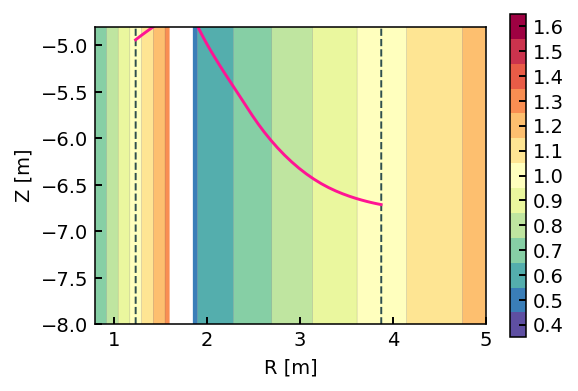

In [18]:
fig, ax = plt.subplots(figsize = (4.5,3))

cmap = "Spectral_r"
datarange = (0.4, 1.6)
step = 0.1

# ax.set_title("Flux expansion factor")
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["Thin"]["BxBt_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["Thin"]["BxBt_relative"], datarange = datarange, step = step, cmap = cmap, cbar = False)

ax = format_axes(ax)

# fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_fR_factor.{save_format}", format = save_format)

## Lc factor

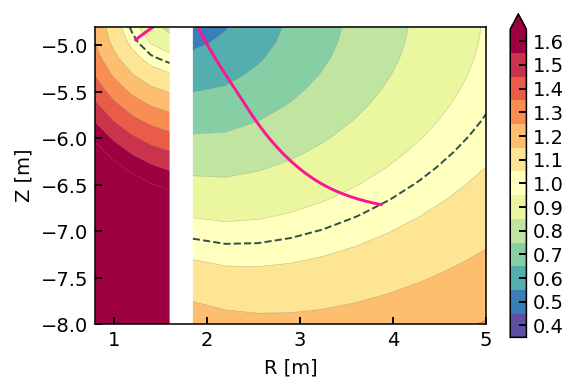

In [19]:
fig, ax = plt.subplots(figsize = (4.5,3))

cmap = "Spectral_r"
datarange = (0.4, 1.6)
step = 0.1

# ax.set_title("Connection length factor")
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["Thin"]["Lc_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max")
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["Thin"]["Lc_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max",  cbar = False)

ax = format_axes(ax)

# fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_Lc_factor.{save_format}", format = save_format)

## All together

In [29]:
def add_cbar(cax, fig, datarange, step, cmap, extend, step_mult = 1):
    
    levels = np.arange(datarange[0], datarange[1] + step, step) - step/2
    levels_for_ticks = np.arange(datarange[0], datarange[1] + step*step_mult, step*step_mult) - step*step_mult/2
    ticks = levels_for_ticks[:-1] + (step * step_mult) / 2  # Midpoints of each segment
    
    # norm = create_norm(False, None, *datarange)
    norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=mpl.colormaps.get_cmap(cmap).N)
    
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    
    cbar = fig.colorbar(mappable, cax = cax, 
                        spacing = "proportional", 
                        extend = "max")
    cbar.ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x)))
    cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize = 8)
    

In [164]:
ax[0].transAxes

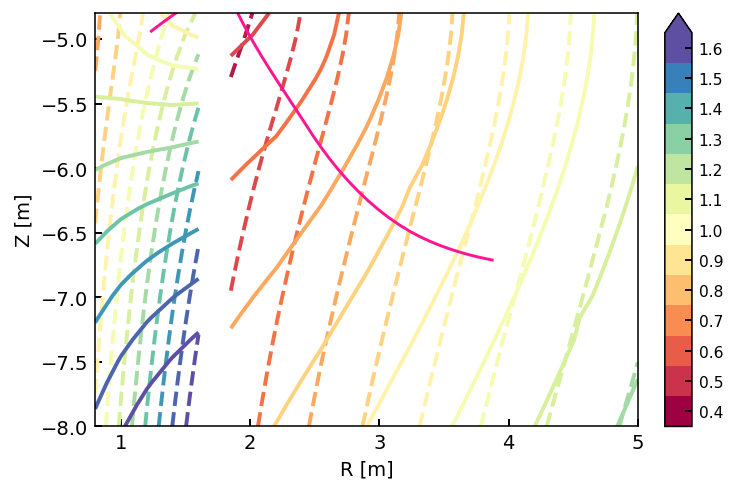

In [168]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patheffects as path_effects
second_curve = "Argon"

fig, ax = plt.subplots()
cmap = "Spectral"
# cmap = "BrBG"
datarange = (0.4, 1.6)
step = 0.1

# ax = axes[0,0]
cf1 = make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = 1/arrays["outer"]["Thin"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max", cbar = False, linesonly = True, breakpoint_line = False,
             linesonly_kwargs = {"linestyles":"--"})
cf2 = make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = 1/arrays["inner"]["Thin"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max", cbar = False, linesonly = True, breakpoint_line = False,
             linesonly_kwargs = {"linestyles":"--"})

# ax = axes[0,1]
cf3 = make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = 1/arrays["outer"][second_curve]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max", cbar = False, linesonly = True, breakpoint_line = False)
cf4 = make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = 1/arrays["inner"][second_curve]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, cbar = False, extend = "max", linesonly = True, breakpoint_line = False)

cax = inset_axes(ax, width="5%", height="100%", loc="lower left",
                  bbox_to_anchor=(1.05, 0, 1, 1),
                  bbox_transform=ax.transAxes, borderpad=0)

cbar = add_cbar(cax, fig, datarange, step, cmap, extend = "max")

ax = format_axes(ax)


# cf1.clabel(inline = True, fontsize = 8)
# cf2.clabel(inline = True, fontsize = 8)
# cf3.clabel(inline = True, fontsize = 8)
# cf4.clabel(inline = True, fontsize = 8)

## Attempt with ratio

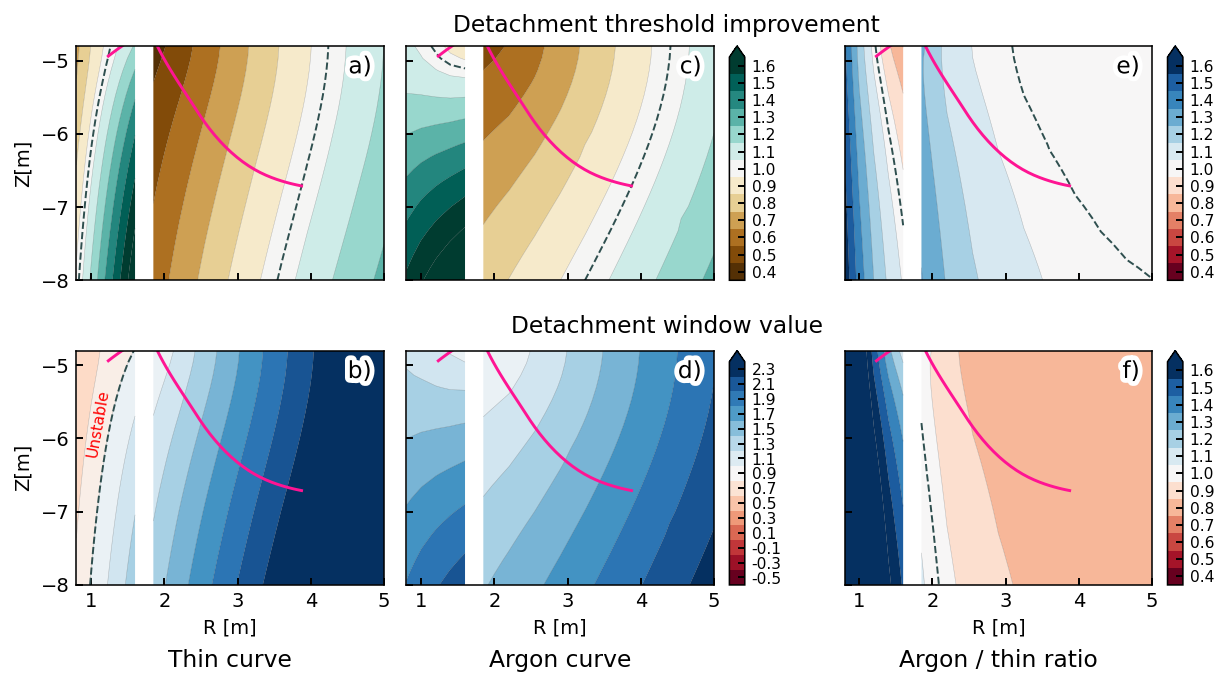

In [196]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patheffects as path_effects
second_curve = "Argon"

fig = plt.figure(constrained_layout = False)

gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 0.3, 1])
axes = np.empty((2,3), dtype=object)

axes[0,0] = fig.add_subplot(gs[0, 0])
axes[1,0] = fig.add_subplot(gs[1, 0])
axes[0,1] = fig.add_subplot(gs[0, 1])
axes[1,1] = fig.add_subplot(gs[1, 1])
axes[0,2] = fig.add_subplot(gs[0, 3])
axes[1,2] = fig.add_subplot(gs[1, 3])

fig.subplots_adjust(wspace = 0.05)
fig.subplots_adjust(hspace=0.3)
fig.set_size_inches(10,5)


# cax1 = fig.add_subplot(gs[0, 2])
# cax2 = fig.add_subplot(gs[1, 2])

cmap = "BrBG"
datarange = (0.4, 1.6)
step = 0.1

ax = axes[0,0]
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = 1/arrays["outer"]["Thin"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max", cbar = False)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = 1/arrays["inner"]["Thin"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max", cbar = False)

ax = axes[0,1]
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = 1/arrays["outer"][second_curve]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max", cbar = False)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = 1/arrays["inner"][second_curve]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, cbar = False, extend = "max")

cax1 = inset_axes(axes[0,1], width="5%", height="100%", loc="lower left",
                  bbox_to_anchor=(1.05, 0., 1, 1),
                  bbox_transform=axes[0,1].transAxes, borderpad=0)

cbar = add_cbar(cax1, fig, datarange, step, cmap, extend = "max")


cmap = "RdBu"
extent = 1.5
datarange = (1-extent, 1+extent)
step = 0.2

kwargs = dict(datarange = datarange, step = step, cmap = cmap, step_mult = 2, extend = "max")

ax = axes[1,0]
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["Thin"]["window_ratio"], cbar = False, **kwargs)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["Thin"]["window_ratio"], cbar = False, **kwargs)

ax = axes[1,1]
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"][second_curve]["window_ratio"], cbar = False, **kwargs)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"][second_curve]["window_ratio"], cbar = False, **kwargs)

cax2 = inset_axes(axes[1,1], width="5%", height="100%", loc="lower left",
                  bbox_to_anchor=(1.05, 0, 1, 1),
                  bbox_transform=axes[1,1].transAxes, borderpad=0)

cbar = add_cbar(cax2, fig, datarange, step, cmap, extend = "max")

cmap = "RdBu"
extent = 0.6
datarange = (1-extent, 1+extent)
step = 0.1
kwargs = dict(datarange = datarange, step = step, cmap = cmap, step_mult = 2, extend = "max")
breakpoint_line = True

ax = axes[0,2]
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], 
             array = (1/arrays["outer"][second_curve]["thresholds_relative"]) / (1/arrays["outer"]["Thin"]["thresholds_relative"]), 
             cbar = False, breakpoint_line = breakpoint_line, **kwargs)

make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], 
             array = (1/arrays["inner"][second_curve]["thresholds_relative"]) / (1/arrays["inner"]["Thin"]["thresholds_relative"]), 
             cbar = False, breakpoint_line = breakpoint_line, **kwargs)

ax = axes[1,2]
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], 
             array =  arrays["outer"][second_curve]["window_ratio"] / arrays["outer"]["Thin"]["window_ratio"], 
             cbar = False, breakpoint_line = breakpoint_line, **kwargs)

make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], 
             array =  arrays["inner"][second_curve]["window_ratio"] / arrays["inner"]["Thin"]["window_ratio"], 
             cbar = False, breakpoint_line = breakpoint_line, **kwargs)


cax3 = inset_axes(axes[0,2], width="5%", height="100%", loc="lower left",
                  bbox_to_anchor=(1.05, 0, 1, 1),
                  bbox_transform=axes[0,2].transAxes, borderpad=0)
cbar = add_cbar(cax3, fig, datarange, step, cmap, extend = "max")

cax4 = inset_axes(axes[1,2], width="5%", height="100%", loc="lower left",
                  bbox_to_anchor=(1.05, 0, 1, 1),
                  bbox_transform=axes[1,2].transAxes, borderpad=0)
cbar = add_cbar(cax4, fig, datarange, step, cmap, extend = "max")


for ax in axes.flatten():
    ax = format_axes(ax)

for i in [0,1,2]:
    axes[0,i].set_xlabel("")
    axes[0,i].tick_params(labelbottom=False)
    
for i in [0,1]:
    for j in [1,2]:
        axes[i,j].set_ylabel("")
        axes[i,j].tick_params(labelleft=False)
        axes[i,j].set_ylabel("")
    
axes[1,0].set_title("Thin curve", y = -0.4)
axes[1,1].set_title(f"{second_curve} curve", y = -0.4)
axes[1,2].set_title(f"{second_curve} / thin ratio", y = -0.4)
axes[0,0].text(0.55, 0.9, "Detachment threshold improvement", transform = fig.transFigure, fontsize = 12, ha = "center")
axes[0,0].text(0.55, 0.47, "Detachment window value", transform = fig.transFigure, fontsize = 12, ha = "center")
axes[0,0].set_ylabel("Z[m]")
axes[1,0].set_ylabel("Z[m]")

figlabels = []
figlabels.append(axes[0,0].text(0.96,0.96, "a)", transform = axes[0,0].transAxes, fontsize = 12, ha = "right", va = "top"))
figlabels.append(axes[0,1].text(0.96,0.96, "c)", transform = axes[0,1].transAxes, fontsize = 12, ha = "right", va = "top"))
figlabels.append(axes[0,2].text(0.96,0.96, "e)", transform = axes[0,2].transAxes, fontsize = 12, ha = "right", va = "top"))
figlabels.append(axes[1,0].text(0.96,0.96, "b)", transform = axes[1,0].transAxes, fontsize = 12, ha = "right", va = "top"))
figlabels.append(axes[1,1].text(0.96,0.96, "d)", transform = axes[1,1].transAxes, fontsize = 12, ha = "right", va = "top"))
figlabels.append(axes[1,2].text(0.96,0.96, "f)", transform = axes[1,2].transAxes, fontsize = 12, ha = "right", va = "top"))

for label in figlabels:
    label.set_path_effects([
    path_effects.Stroke(linewidth=5, foreground="white"),
    path_effects.Normal()
])
    
axes[1,0].text(0.028, 0.69, "Unstable", transform = axes[1,0].transAxes, fontsize = 8, ha = "left", va = "center", rotation = 80, color = "red")
fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_all.pdf", format = "pdf")


## Working - 2x2

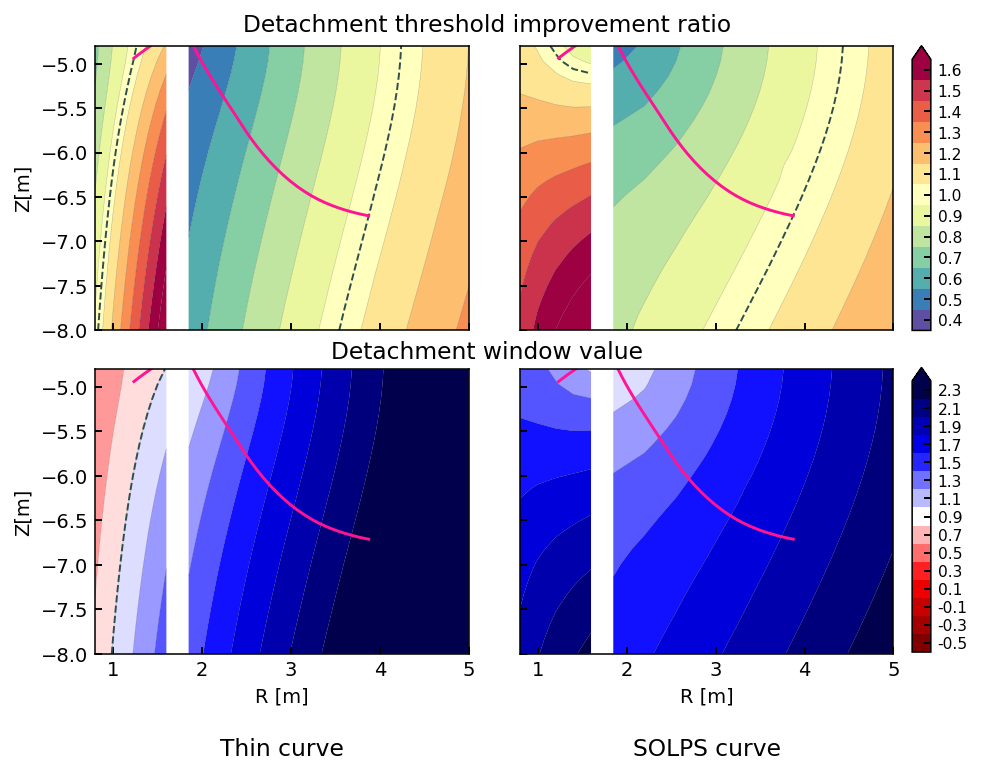

In [91]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(constrained_layout = False)

gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.05])
axes = np.empty((2,2), dtype=object)

axes[0,0] = fig.add_subplot(gs[0, 0])
axes[1,0] = fig.add_subplot(gs[1, 0])
axes[0,1] = fig.add_subplot(gs[0, 1])
axes[1,1] = fig.add_subplot(gs[1, 1])

# cax1 = fig.add_subplot(gs[0, 2])
# cax2 = fig.add_subplot(gs[1, 2])

cmap = "Spectral_r"
datarange = (0.4, 1.6)
step = 0.1

ax = axes[0,0]
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = 1/arrays["outer"]["Thin"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max", cbar = False)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = 1/arrays["inner"]["Thin"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max", cbar = False)

ax = axes[0,1]
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = 1/arrays["outer"]["SOLPS"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max", cbar = False)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = 1/arrays["inner"]["SOLPS"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, cbar = False, extend = "max")

cax1 = inset_axes(axes[0,1], width="5%", height="100%", loc="lower left",
                  bbox_to_anchor=(1.05, 0., 1, 1),
                  bbox_transform=axes[0,1].transAxes, borderpad=0)

cbar = add_cbar(cax1, fig, datarange, step, cmap, extend = "max")


cmap = "seismic_r"
extent = 1.5
datarange = (1-extent, 1+extent)
step = 0.2

kwargs = dict(datarange = datarange, step = step, cmap = cmap, step_mult = 2, extend = "max")

ax = axes[1,0]
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["Thin"]["window_ratio"], cbar = False, **kwargs)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["Thin"]["window_ratio"], cbar = False, **kwargs)

ax = axes[1,1]
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["SOLPS"]["window_ratio"], cbar = False, **kwargs)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["SOLPS"]["window_ratio"], cbar = False, **kwargs)

cax2 = inset_axes(axes[1,1], width="5%", height="100%", loc="lower left",
                  bbox_to_anchor=(1.05, -1.13, 1, 1),
                  bbox_transform=axes[0,1].transAxes, borderpad=0)

cbar = add_cbar(cax2, fig, datarange, step, cmap, extend = "max")


for ax in axes.flatten():
    ax = format_axes(ax)

for i in [0,1]:
    axes[0,i].set_xlabel("")
    axes[0,i].tick_params(labelbottom=False)
    axes[i,1].set_ylabel("")
    axes[i,1].tick_params(labelleft=False)
    axes[i,1].set_ylabel("")
    
axes[1,0].set_title("Thin curve", y = -0.4)
axes[1,1].set_title("SOLPS curve", y = -0.4)
axes[0,0].text(1.05, 1.05, "Detachment threshold improvement ratio", transform = axes[0,0].transAxes, fontsize = 12, ha = "center")
axes[0,0].text(1.05, -0.1, "Detachment window value", transform = axes[0,0].transAxes, fontsize = 12, ha = "center")
axes[0,0].set_ylabel("Z[m]")
axes[1,0].set_ylabel("Z[m]")
fig.subplots_adjust(hspace=0)
fig.set_size_inches(8,6)

In [171]:
axes[0,0].label

AttributeError: 'Axes' object has no attribute 'label'

## Threshold

## Threshold, thin

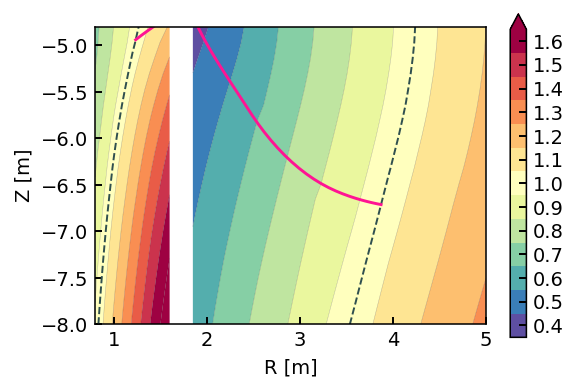

In [20]:
fig, ax = plt.subplots(figsize = (4.5,3))

cmap = "Spectral_r"
datarange = (0.4, 1.6)
step = 0.1

# datarange = (0.9, 1.1)
# step = 0.02


# ax.set_title("Thin curve")
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = 1/arrays["outer"]["Thin"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max")
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = 1/arrays["inner"]["Thin"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max", cbar = False)

ax = format_axes(ax)

# fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_threshold_thin.{save_format}", format = save_format)

## Threshold, SOLPS

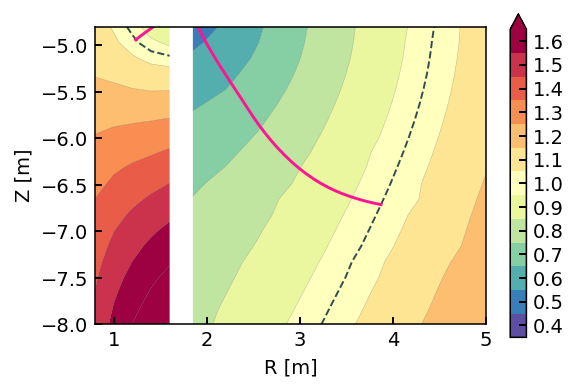

In [21]:
fig, ax = plt.subplots(figsize = (4.5,3))

cmap = "Spectral_r"
datarange = (0.4, 1.6)
step = 0.1

# datarange = (0.9, 1.1)
# step = 0.02

# ax.set_title("Thin curve")
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = 1/arrays["outer"]["SOLPS"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, extend = "max")
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = 1/arrays["inner"]["SOLPS"]["thresholds_relative"], 
             datarange = datarange, step = step, cmap = cmap, cbar = False, extend = "max")

ax = format_axes(ax)

# fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_threshold_solps.{save_format}", format = save_format)

## Threshold ratio

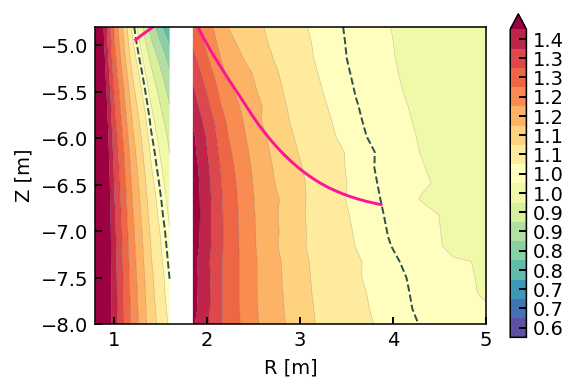

In [24]:
fig, ax = plt.subplots(figsize = (4.5,3))

cmap = "Spectral_r"
extent = 0.4
datarange = (1-extent, 1+extent)
step = 0.05

# datarange = (0.9, 1.1)
# step = 0.02

# ax.set_title("Thin curve")
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], 
             array = (1/arrays["outer"]["SOLPS"]["thresholds_relative"]) / (1/arrays["outer"]["Thin"]["thresholds_relative"]), 
             datarange = datarange, step = step, cmap = cmap, extend = "max")

make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], 
             array = (1/arrays["inner"]["SOLPS"]["thresholds_relative"]) / (1/arrays["inner"]["Thin"]["thresholds_relative"]), 
             datarange = datarange, step = step, cmap = cmap, cbar = False, extend = "max")

ax = format_axes(ax)

# fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_threshold_solps.{save_format}", format = save_format)

## Window

## Window, thin

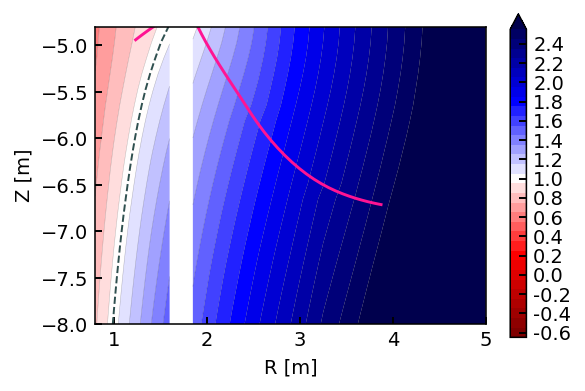

In [63]:
fig, ax = plt.subplots(figsize = (4.5,3))

cmap = "seismic_r"
extent = 1.6
datarange = (1-extent, 1+extent)
step = 0.1

kwargs = dict(datarange = datarange, step = step, cmap = cmap, step_mult = 2, extend = "max")

# ax.set_title("Thin curve")
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["Thin"]["window_ratio"], **kwargs)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["Thin"]["window_ratio"], cbar = False, **kwargs)

ax = format_axes(ax)

fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_window_thin.{save_format}", format = save_format)

## Window, SOLPS

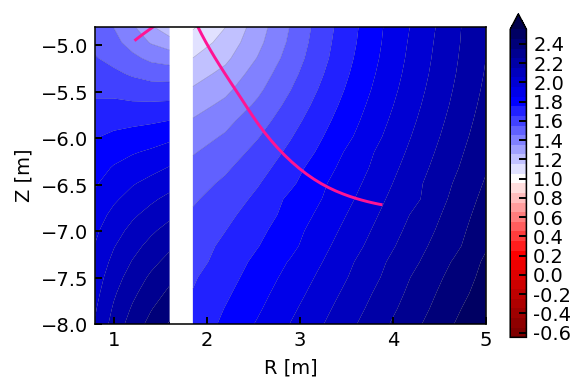

In [64]:
fig, ax = plt.subplots(figsize = (4.5,3))

cmap = "seismic_r"
extent = 1.6
datarange = (1-extent, 1+extent)
step = 0.1

kwargs = dict(datarange = datarange, step = step, cmap = cmap, step_mult = 2, extend = "max")

# ax.set_title("Thin curve")
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["SOLPS"]["window_ratio"], **kwargs)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["SOLPS"]["window_ratio"], cbar = False, **kwargs)

ax = format_axes(ax)

fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_window_solps.{save_format}", format = save_format)

## Window ratio

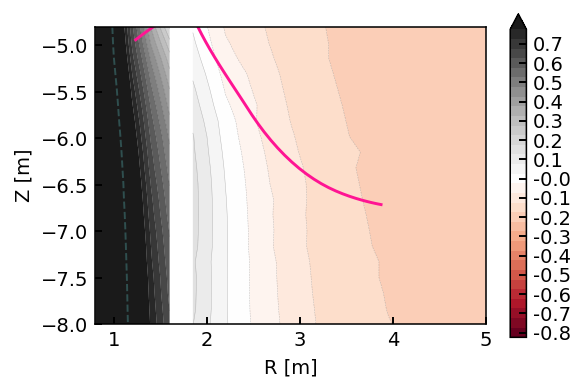

In [39]:
fig, ax = plt.subplots(figsize = (4.5,3))

cmap = "seismic_r"
extent = 0.8
datarange = (-extent, +extent)
step = 0.05

kwargs = dict(datarange = datarange, step = step, cmap = "RdGy", step_mult = 2, extend = "max")

# ax.set_title("Thin curve")
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["SOLPS"]["window_ratio"] / arrays["outer"]["Thin"]["window_ratio"] - 1, **kwargs)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["SOLPS"]["window_ratio"] / arrays["inner"]["Thin"]["window_ratio"] - 1, cbar = False, **kwargs)

ax = format_axes(ax)

# fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_window_solps.{save_format}", format = save_format)

In [30]:
arrays["inner"]["SOLPS"]["window_ratio"]

array([[1.50633322, 1.44775141, 1.36523283, 1.2644777 , 1.17318487],
       [1.52666799, 1.47821081, 1.41210935, 1.34241641, 1.29743011],
       [1.55614261, 1.51995002, 1.47260002, 1.42768569, 1.40611549],
       [1.59001312, 1.56911255, 1.53732785, 1.51236399, 1.50352979],
       [1.62717337, 1.62025614, 1.60277402, 1.59059281, 1.59246336],
       [1.66748924, 1.67219489, 1.66576267, 1.66645772, 1.67147645],
       [1.70518217, 1.71845509, 1.72735568, 1.7364468 , 1.75115987],
       [1.74263165, 1.76832048, 1.78497351, 1.80127796, 1.82709906],
       [1.77792635, 1.815103  , 1.84134792, 1.86437674, 1.89168208],
       [1.81247133, 1.85799084, 1.89281791, 1.92050386, 1.95585547],
       [1.83933336, 1.89936181, 1.94183795, 1.97965554, 2.01610638],
       [1.87859526, 1.93460539, 1.98775543, 2.03354742, 2.07505023],
       [1.90330476, 1.97606755, 2.03386636, 2.08262187, 2.1290233 ],
       [1.93187463, 2.01131638, 2.07640394, 2.13295548, 2.18505748],
       [1.95435681, 2.04446124, 2.

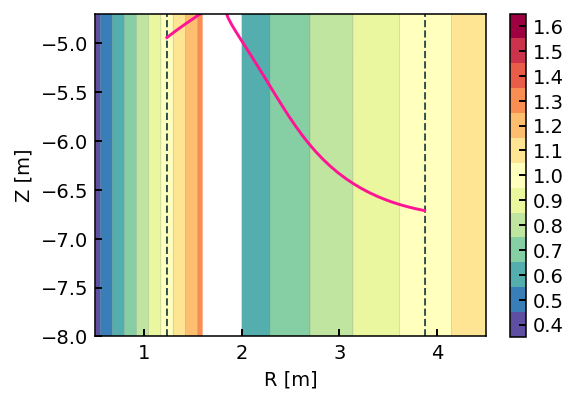

In [ ]:
fig, ax = plt.subplots(figsize = (4.5,3))

cmap = "Spectral_r"
datarange = (0.4, 1.6)
step = 0.1

# ax.set_title("Flux expansion factor")
make_contour(ax = ax, xpoints=xpoints["outer"], ypoints=ypoints["outer"], array = arrays["outer"]["Thin"]["BxBt_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = ax, xpoints=xpoints["inner"], ypoints=ypoints["inner"], array = arrays["inner"]["Thin"]["BxBt_relative"], datarange = datarange, step = step, cmap = cmap, cbar = False)

ax = format_axes(ax)

# fig.savefig(fr"C:\Users\Mike\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_fR_factor.{save_format}", format = save_format)

# Lineplot

In [92]:
xpoints["outer"]

array([1.85, 2.2 , 2.55, 2.9 , 3.25, 3.6 , 3.95, 4.3 , 4.65, 5.  ])

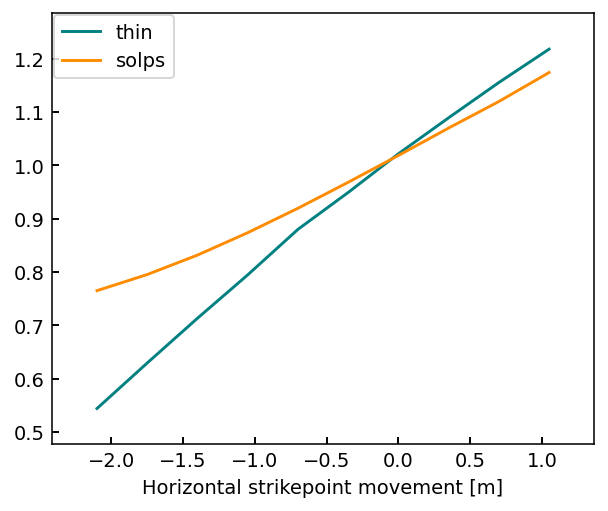

In [ ]:


fig, ax = plt.subplots()

ax.plot(x, thresh_outer_thin[y_idx_base,:], label = "thin")
ax.plot(x, thresh_outer_solps[y_idx_base,:], label = "solps")
ax.set_xlabel("Horizontal strikepoint movement [m]")
ax.legend()

Thin curve gradient: 0.2144 per meter
SOLPS curve gradient: 0.1321 per meter
A REDUCTION OF 38.374%


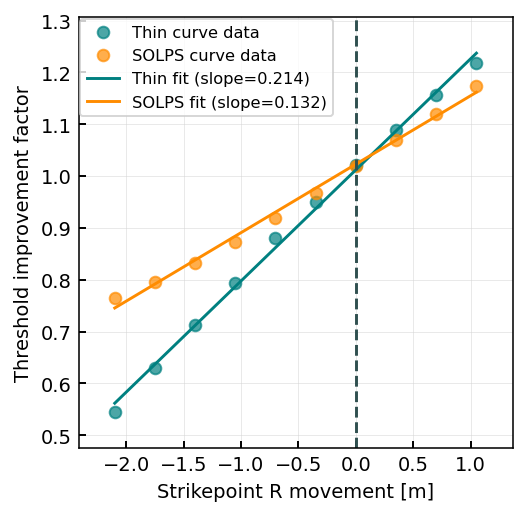

In [159]:
thresh_outer_solps = 1/arrays["outer"]["SOLPS"]["thresholds_relative"]
thresh_outer_thin = 1/arrays["outer"]["Thin"]["thresholds_relative"]
x = xpoints["outer"] - 3.95

y_idx_base = np.abs(ypoints["outer"] - -6.82105263).argmin()

# Calculate linear regression for both curves
slope_thin, intercept_thin = np.polyfit(x, thresh_outer_thin[y_idx_base,:], 1)
slope_solps, intercept_solps = np.polyfit(x, thresh_outer_solps[y_idx_base,:], 1)

# Print the results
print(f"Thin curve gradient: {slope_thin:.4f} per meter")
print(f"SOLPS curve gradient: {slope_solps:.4f} per meter")

# Plot with regression lines
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(x, thresh_outer_thin[y_idx_base,:], 'o', c = "C0", label="Thin curve data", alpha=0.7)
ax.plot(x, thresh_outer_solps[y_idx_base,:], 'o', c = "C1", label="SOLPS curve data", alpha=0.7)

# Plot regression lines
ax.plot(x, slope_thin * x + intercept_thin, '-', c = "C0", label=f"Thin fit (slope={slope_thin:.3f})")
ax.plot(x, slope_solps * x + intercept_solps, '-', c = "C1", label=f"SOLPS fit (slope={slope_solps:.3f})")

ylims = ax.get_ylim()
ax.vlines(0, ylims[0], ylims[1], color='darkslategrey', linestyle='--', lw=1.5)
ax.set_ylim(ylims)

ax.set_xlabel("Strikepoint R movement [m]")
ax.set_ylabel("Threshold improvement factor")
ax.legend(fontsize = "small")
# ax.set_title("a) Detachment threshold")
print(f"A REDUCTION OF {1-slope_solps / slope_thin:.3%}")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.grid()
fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_R_threshold_sensitivity.{save_format}", format = save_format)

In [115]:
arrays["outer"]["SOLPS"].keys()

dict_keys(['BxBt', 'BxBteff', 'Lc', 'thresholds', 'BxBt_relative', 'BxBteff_relative', 'Lc_relative', 'thresholds_relative', 'unstable_Lpol_backward', 'window_ratio'])

Thin curve gradient: 0.5377 per meter
SOLPS curve gradient: 0.2700 per meter
A REDUCTION OF 49.777%


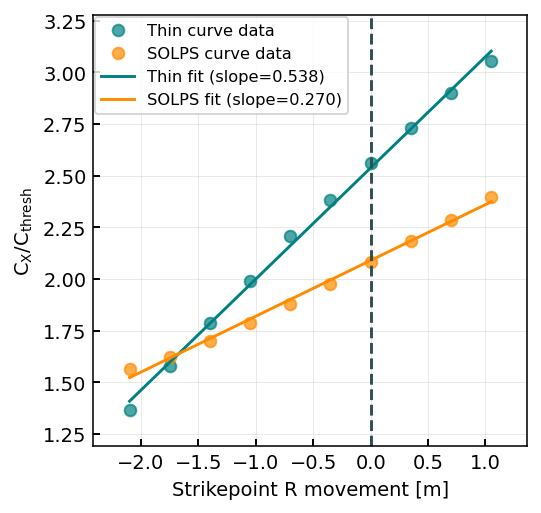

In [160]:
window_outer_solps = arrays["outer"]["SOLPS"]["window_ratio"]
window_inner_solps = arrays["outer"]["Thin"]["window_ratio"]
x = xpoints["outer"] - 3.95

y_idx_base = np.abs(ypoints["outer"] - -6.82105263).argmin()

# Calculate linear regression for both curves
slope_thin, intercept_thin = np.polyfit(x, window_inner_solps[y_idx_base,:], 1)
slope_solps, intercept_solps = np.polyfit(x, window_outer_solps[y_idx_base,:], 1)

# Print the results
print(f"Thin curve gradient: {slope_thin:.4f} per meter")
print(f"SOLPS curve gradient: {slope_solps:.4f} per meter")

# Plot with regression lines
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(x, window_inner_solps[y_idx_base,:], 'o', c = "C0", label="Thin curve data", alpha=0.7)
ax.plot(x, window_outer_solps[y_idx_base,:], 'o', c = "C1", label="SOLPS curve data", alpha=0.7)

# Plot regression lines
ax.plot(x, slope_thin * x + intercept_thin, '-', c = "C0", label=f"Thin fit (slope={slope_thin:.3f})")
ax.plot(x, slope_solps * x + intercept_solps, '-', c = "C1", label=f"SOLPS fit (slope={slope_solps:.3f})")

ylims = ax.get_ylim()
ax.vlines(0, ylims[0], ylims[1], color='darkslategrey', linestyle='--', lw=1.5)
ax.set_ylim(ylims)

ax.set_xlabel("Strikepoint R movement [m]")
ax.set_ylabel(r"$C_X / C_{thresh}$")
# ax.set_title(r"b) Detachment window")
ax.legend(fontsize = "small")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.grid()
print(f"A REDUCTION OF {1-slope_solps / slope_thin:.3%}")
fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\StrikePointScan_R_window_sensitivity.{save_format}", format = save_format)

In [151]:
window_solps = slope_solps * 0 + intercept_solps
window_thin = slope_thin * 0 + intercept_thin
print(f"Window SOLPS: {window_solps:.3f}, Thin: {window_thin:.3f}")
print(f"Reduction: {1-window_solps / window_thin:.3%}")

Window SOLPS: 2.090, Thin: 2.538
Reduction: 17.649%


In [ ]:
thresh_outer_solps.shape

(20, 10)

# Debug plot baseline

In [36]:
print("Base target RZ")

print(f'R: {base["R"][0]}')
print(f'Z: {base["Z"][0]}')

Base target RZ
R: 3.8735787825
Z: -6.711390375


In [80]:
profiles_constBpol["outer"][3.9].keys()

dict_keys([-4.65, -5.336, -6.022, -6.708, -7.394, -8.08])

In [ ]:
lengths = {}

side = "outer"


33.62588226732601
31.735619963731555


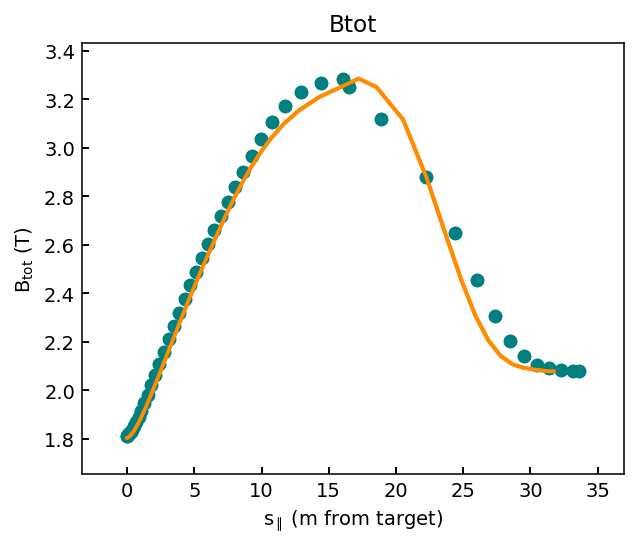

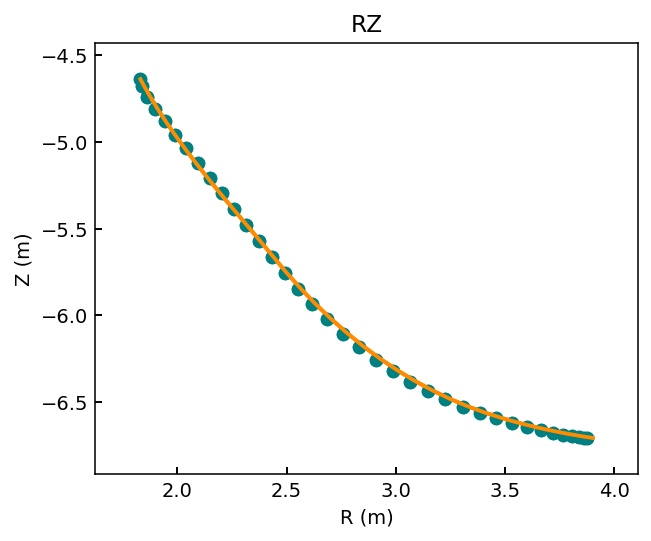

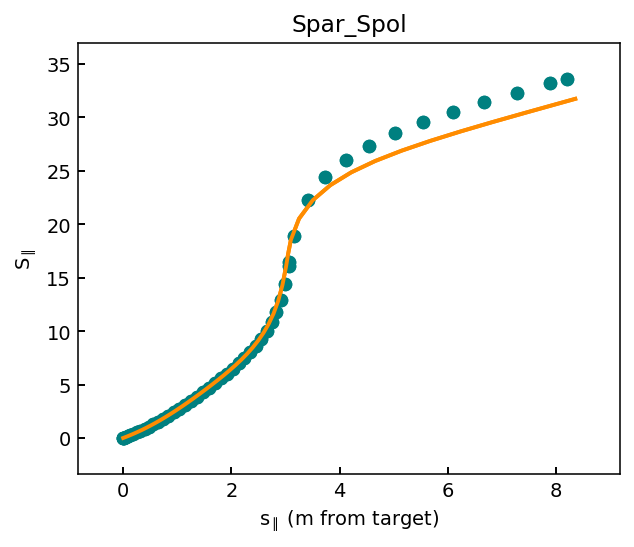

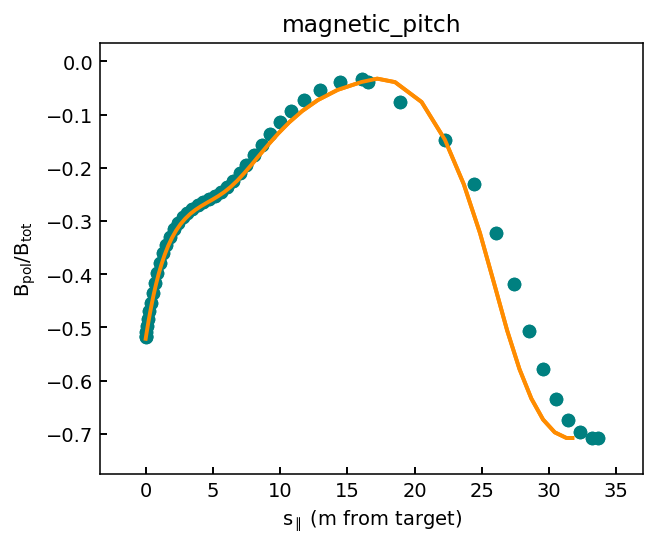

In [84]:
base = base_profile["outer"]
test = profiles_constBpol["outer"][3.9][-6.708]
print(base.connection_length)
print(test.connection_length)

for mode in ["Btot", "RZ", "Spar_Spol", "magnetic_pitch"]:
    fig, ax = plt.subplots()
    ax.set_title(mode)
    for profile in [base, test]:
        base.plot(mode= mode, ax = ax, marker = "o", lw = 0)
        test.plot(mode=mode, ax=ax, color = "darkorange", lw = 2)


# Other

256.00229335620685

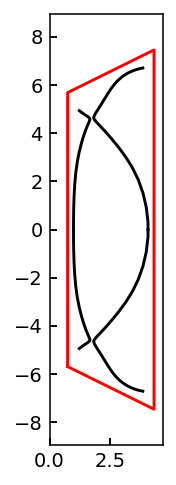

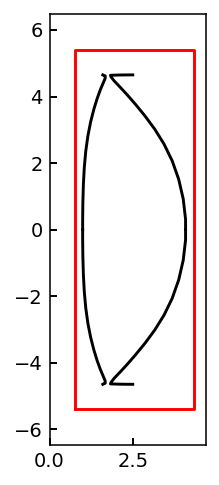

In [168]:
inner_profile = base_profile["inner"]
outer_profile = base_profile["outer"]
# inner_profile = profiles_constBpol["inner"][1.6][-4.65]
# outer_profile = profiles_constBpol["outer"][2.5][-4.65]


def get_coil_volume(inner_profile, outer_profile, plot = False):
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(inner_profile["R"], inner_profile["Z"], c = "k", lw = 1.5)
        ax.plot(inner_profile["R"], -inner_profile["Z"], c = "k", lw = 1.5)
        ax.plot(outer_profile["R"], outer_profile["Z"], c = "k", lw = 1.5)
        ax.plot(outer_profile["R"], -outer_profile["Z"], c = "k", lw = 1.5)

    outer_max_height = -np.min(outer_profile["Z"]) + 0.75
    inner_max_height = -np.min(inner_profile["Z"]) + 0.75
    outer_max_radius = np.max(outer_profile["R"])
    IR = 0.75
    OR = outer_max_radius + 0.25

    pol = shapely.geometry.Polygon([
        (IR, -inner_max_height),
        (IR, inner_max_height),
        (OR, outer_max_height),
        (OR, -outer_max_height)
    ])
    x, y = pol.exterior.xy
    
    if plot:
        ax.plot(x, y, c = "r")
        ax.set_aspect("equal")
        ax.set_xlim(0, None)

    sorted_coords = sorted(zip(y, x))
    y_sorted, x_sorted = zip(*sorted_coords)

    # Define a function to compute the volume of revolution using the method of disks
    def revolved_volume(y, x):
        volume = 0
        for i in range(1, len(y)):
            r1 = x[i-1]
            r2 = x[i]
            h = y[i] - y[i-1]
            volume += np.pi * h * (r1**2 + r1*r2 + r2**2) / 3
        return volume

    # Compute the revolved volume
    volume = revolved_volume(y_sorted, x_sorted)
    
    return volume

get_coil_volume(base_profile["inner"], base_profile["outer"], plot = True)
get_coil_volume(profiles_constBpol["inner"][1.6][-4.65], outer_profile = profiles_constBpol["outer"][2.5][-4.65]
, plot = True)

104.11206048397008

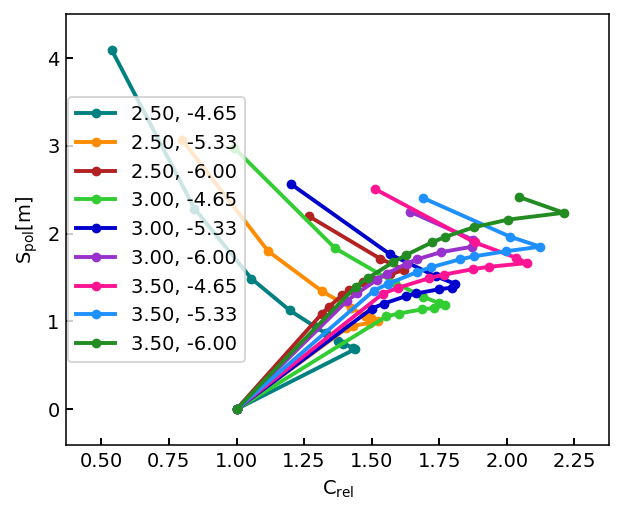

In [48]:
from cycler import cycler
fig, ax = plt.subplots()
default_cycler = cycler(color=plt.rcParamsDefault['axes.prop_cycle'].by_key()['color'])

side = "outer"
with plt.rc_context({'axes.prop_cycle': default_cycler}):
    for x in xpoints[side]:
        for y in ypoints[side]:
            deck = FrontLocationScan(store[side]["Curve 1"][x][y])
            deck.plot_front_movement(ax = ax, label = f"{x:.2f}, {y:.2f}", relative = True)
            # ax.scatter(deck.data["crel_stable"], deck.data["Spol"], c = "k", marker = "x")
            # deck.get_stable_region(diagnostic_plot = True)

    ax.legend()

In [52]:
profiles_constBpol["outer"][3.50].keys()

dict_keys([-4.65, -5.325, -6.0])

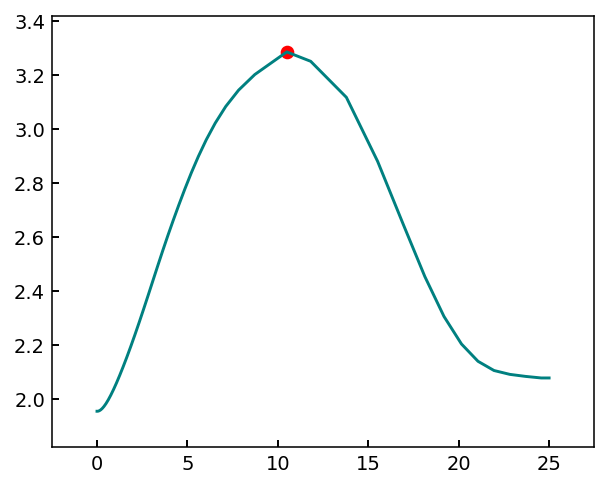

In [57]:
p = profiles_constBpol["outer"][3.50][-5.325]
deck = FrontLocationScan(store["outer"]["Curve 1"][3.50][-5.325])

fig, ax = plt.subplots()
ax.plot(p["S"], p["Btot"])
ax.scatter(p["S"][p["Xpoint"]], p["Btot"][p["Xpoint"]], c = "r")

# profiles_constBpol["outer"][3.50][-5.325].plot(mode = "Btot")

Text(0.5, 1.05, 'Radiated power, parallel heat flux and temperature for two front positions')

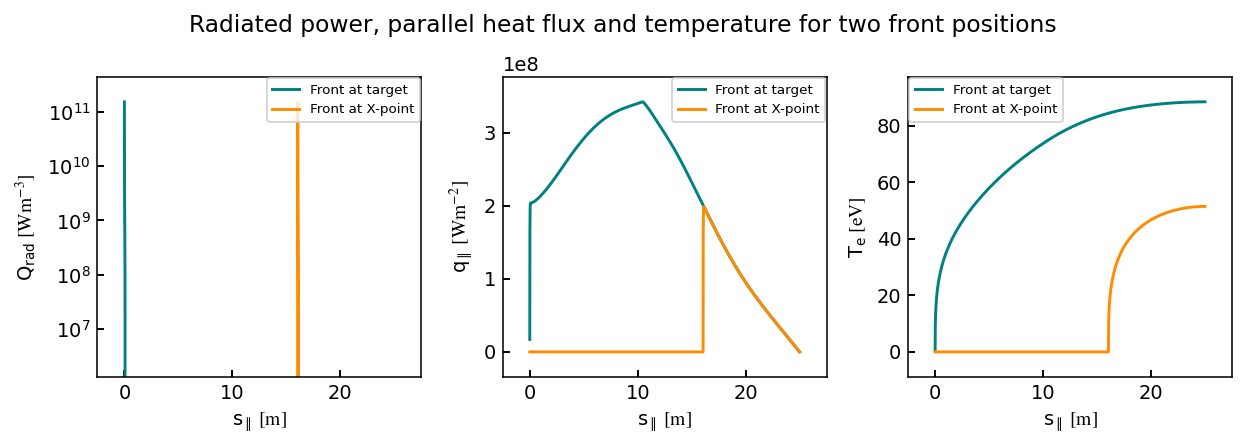

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
labels = ["Front at target", "Front at X-point"]

## Plot 1D profiles along field line for the first and final front solution in the scan
for i, position_index in enumerate([0, -1]):
    front_solution = deck.FrontLocations[position_index]

    axes[0].plot(
        front_solution.data["Spar"],
        front_solution.data["Qrad"],
        label=labels[i],
    )

    axes[1].plot(
        front_solution.data["Spar"],
        front_solution.data["qpar"],
        label=labels[i],
    )
    axes[2].plot(
        front_solution.data["Spar"],
        front_solution.data["Te"],
        label=labels[i],
    )

axes[0].set_ylabel(r"$Q_{rad}\ \mathrm{[Wm^{-3}]}$")
axes[1].set_ylabel(r"$q_{\parallel}\ \mathrm{[Wm^{-2}]}$")
axes[2].set_ylabel(r"$T_{e}\ \mathrm{[eV]}$")
axes[0].set_yscale("log")
for ax in axes:
    ax.set_xlabel(r"$s_{\parallel}\ \mathrm{[m]}$")
    ax.legend(fontsize="x-small")

fig.tight_layout()
fig.suptitle(
    "Radiated power, parallel heat flux and temperature for two front positions", y=1.05
)

## Sensitivity

NameError: name 'xpoints_inner' is not defined

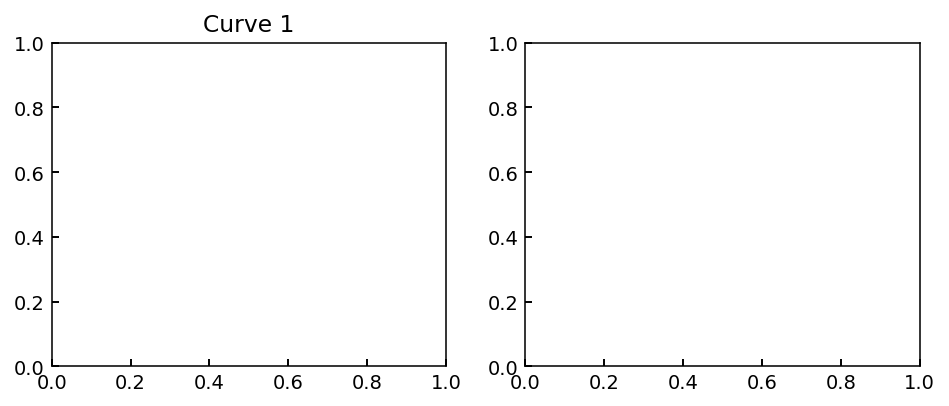

In [178]:
fig, axes = plt.subplots(1,2, figsize = (8,3))

cmap = "RdBu"
study = "Curve 1"
datarange = (0.2, 2.2)
step = 0.2

axes[0].set_title("Curve 1")
# make_contour(ax = axes[0], xpoints=xpoints_outer, ypoints=ypoints_outer, array = 1/arrays_outer["Curve 1"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[0], xpoints=xpoints_inner, ypoints=ypoints_inner, array = arrays_inner["Curve 1"]["window_ratio"], datarange = datarange, step = step, cmap = cmap, cbar = True)

axes[1].set_title("SOLPS curve")
# make_contour(ax = axes[1], xpoints=xpoints_outer, ypoints=ypoints_outer, array = 1/arrays_outer["SOLPS"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[1], xpoints=xpoints_inner, ypoints=ypoints_inner, array = 1/arrays_inner["SOLPS"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap, cbar = True)

for ax in axes:
  base_profile_inner.plot(mode = "RZ", ax = ax, color = "black")
  base_profile_outer.plot(mode = "RZ", ax = ax, color = "black")
  ax.set_aspect("equal")
  ax.set_xlabel("R [m]")
  ax.set_ylabel("Z [m]")
  ax.set_ylim(-8, -4.7)
  ax.set_xlim(0.5, 4.5)
  ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
  # ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
  # ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
  # ax.grid(which = "major", linestyle = "-", c = "k", alpha = 0.1)
  # ax.grid(which = "minor", c = "k", alpha = 0.05)
fig.subplots_adjust(wspace = 0.2)

